# KaaS Benchmarking Results
This notebook processes the results from all KaaS experiments used in the paper(s). Most of the heavy pre-processing and data ingest is handled in util.py while the notebook itself focuses on plotting and summarizing.

## Experiments
### Micro
**Ingested Data:** microMeans, microStds

**Loaded By:** util.loadMicroSuite()

**Data Generated By:** ./micro.py




In [1]:
import yaml
import pathlib
import pandas as pd
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn
import brokenaxes


import util

In [2]:
# Color style similar to ppt color scheme
plt.style.use('seaborn-colorblind')
# plt.rc('axes', prop_cycle=(plt.cycler('linestyle', ['-', '--', ':', '-.'])))

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})

def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['//'], ['--'], ['x'], ['\\'], ['||'], ['+'], ['o'], ['.']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
    ax.legend()

# Data Import and Cleaning

In [3]:
baselineName = 'eTask'
kaasName = 'kTask'

resBaseDir = pathlib.Path("results/osdiRes")
thrResults = util.loadAllThroughput(resBaseDir / "throughputSuite")
# sloResults = util.loadAllMlPerf(resBaseDir / "mlperfSuite", metric='completion_rate')
_, latResults90 = util.loadAllMlPerf(resBaseDir / "latDistribution", metric='p90')
_, latResults50 = util.loadAllMlPerf(resBaseDir / "latDistribution", metric='p50')

microMeans, microStds = util.loadMicroSuite(resBaseDir / 'micro' / 'testModel')

# Latency Distribution

In [4]:
def plotLatencies(lats, title="", log=True):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({baselineName: f"{name} {baselineName}", kaasName: f"{name} {kaasName}"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0) / 1000
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
#     plot = pltDf.plot(kind='line', linewidth=2)
    plot = seaborn.lineplot(data=pltDf, linewidth=3)

    plot.set_ylabel("90th Percentile Latency (s)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

def plotNormalized(lats, log=False):
    plotDf = pd.DataFrame({workloadName: df.Actor / df.KaaS for workloadName, df in lats.items()})
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = plotDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
    plot = plotDf.plot(kind='line', linewidth=2, logy=log)
    plot.set_ylabel("90th Percentile Latency\n(ms)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, plotDf)
    
def plotLatWithConfidence(p50s, p90s, title=None):
    p50s = p50s / 1000
    p90s = p90s / 1000
    
#     p50s = p50s.rename({"Actor": "FaaS"}, axis='columns')
    
    ax = p50s.plot(kind='line', style=['b-', 'g--'], figsize=(5, 4))
    ax.fill_between(p50s.index, p50s[kaasName], p90s[kaasName], color='g', hatch="+", alpha=0.1)
    ax.fill_between(p50s.index, p50s[baselineName], p90s[baselineName], color='b', alpha=0.1)
    
    ax.legend(loc='upper left')
    ax.set_ylabel("Latency (s)")
    ax.set_xlabel("Number of Replicas")
    if title is not None:
        ax.set_title(title)
        
    return ax

resnet50
bert
jacobi
cGEMM


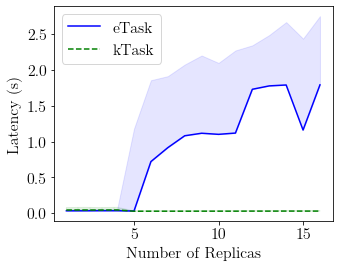

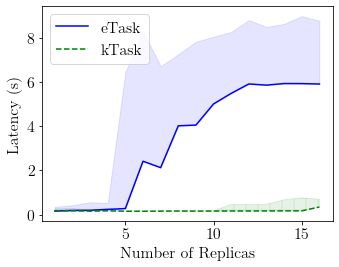

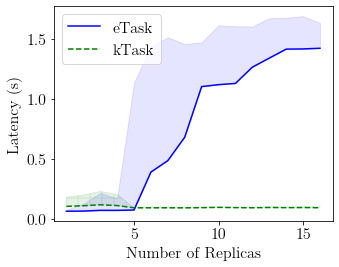

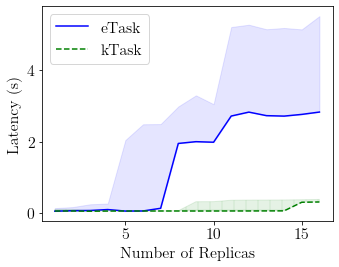

In [19]:
models = ['resnet50', 'bert', 'jacobi', 'cGEMM']
# models = ['resnet50']
# bbox = matplotlib.transforms.Bbox.from_bounds(0, 0, 5, 4)
for model in models:
    p90s = latResults90[model]
    p50s = latResults50[model]

    print(model)
#     ax = plotLatWithConfidence(p50s, p90s, title=model)
    ax = plotLatWithConfidence(p50s, p90s)
#     ax.figure.savefig(f"figs/latDistResults_{model}.png", dpi=300, bbox_inches='tight')
    ax.figure.savefig(f"figs/latDistResults_{model}.png", dpi=300)

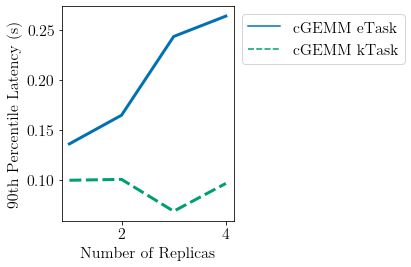

In [6]:
subset = {k: v.loc[:4] for k, v in latResults90.items() if k in ['cGEMM']}
# subset = {k: v for k, v in latResults.items() if k in ['resnet50', 'jacobi']}
# subset = {k: v for k, v in latResults.items() if k in ['resnet50']}
# subset = {k: v.loc[:4] for k, v in latResults.items()}
# subset = {k: v.loc[:,['KaaS']] for k, v in latResults.items()}
# plot = plotLatencies(latResults)
plot = plotLatencies(subset)
# plot = plotLatencies({k: v for k, v in latResults.items() if k in ['resnet50', 'jacobi']}, log=True)
# plot.figure.savefig("figs/latDistResults.png", dpi=300, bbox_inches='tight')

# CDFs

In [7]:
modelRenames = {"complexCutlassGemm": "cGEMM"}
linestyles = [':', '--', '-.', (0, (3, 1, 1, 1, 1, 1)), '-']

def plotCDFs(names, arrs, title=''):
#     fig, ax = plt.subplots(figsize=[6.4, 3.4])
#     fig, ax = plt.subplots(figsize=[6, 3])
    fig, ax = plt.subplots(figsize=[4.5,3.4])
    n, bins, patches = ax.hist(arrs, bins='auto', label=names, cumulative=True, density=True,
                               histtype='step', linewidth=2, linestyle='-')

    # Get rid of the zero value at the end (causes a vertical line)
    for idx, patch in enumerate(patches):
        patch[0].set_linestyle(linestyles[idx])
        patch[0].set_xy(patch[0].get_xy()[:-1])

    ax.set_xlabel("Latency (s)")
    ax.legend(loc='lower right') 
    ax.set_title(title)
    
    return ax


def loadCDFExps(configs):
    results = {}
    for model, mode, nReplica, independent in configs:
        expName = f"{model}_{mode}_{nReplica}"
        if independent:
            dirs = util.getRunDirs(resBaseDir / 'latIndependent', expNames=[expName])
        else:
            dirs = util.getRunDirs(resBaseDir / 'latDistribution', expNames=[expName])
            
        res, _ = util.loadOneMlPerf(dirs[expName])
        
        # Convert any ugly internal names to prettier ones
        if model in modelRenames:
            model = modelRenames[model]
            
        if mode == 'tvm':
#             name = f"{model} Actor ({round(res['submission_rate'], 1)} QPS)"
            name = f"{baselineName} ({round(res['submission_rate'], 1)}/s)"
        else:
#             name = f"{model} KaaS ({round(res['submission_rate'], 1)} QPS)"
            name = f"{kaasName} ({round(res['submission_rate'], 1)}/s)"
        
        lats = res['latencies'] / 1000
        results[name] = lats
        
    return results


def plotOneModelCDF(model, scales):
    if not isinstance(scales, list):
        scales = [scales]
        
    plots = []
    for scale in scales:
        configs = [(model, 'tvm', scale, False),
                   (model, 'kaas', scale, False),
                   (model, 'kaas', scale, True)]

        cdfData = loadCDFExps(configs)
        plots.append((scale, plotCDFs(list(cdfData.keys()), cdfData.values(), title=f"{scale} Replicas ({model})")))
#         plots.append((scale, plotCDFs(list(cdfData.keys()), cdfData.values())))
        
    return plots

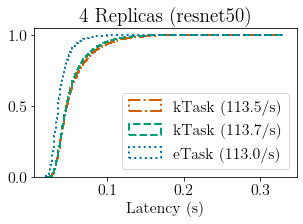

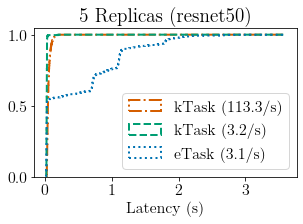

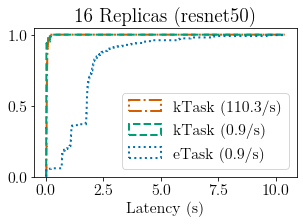

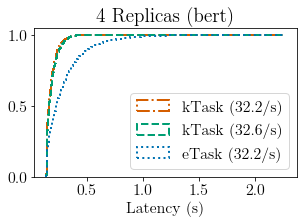

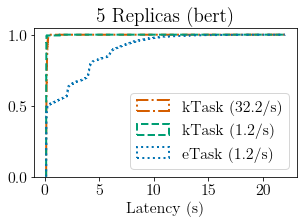

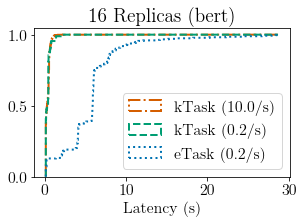

In [8]:
# scale = 2
# configs = [
#     ('complexCutlassGemm', 'tvm', scale, False),
#     ('complexCutlassGemm', 'kaas', scale, False)
# ]
# configs = [
#     ('bert', 'tvm', scale, False),
#     ('bert', 'kaas', scale, False),
#     ('jacobi', 'tvm', scale, False),
#     ('jacobi', 'kaas', scale, False),
# ]
# cdfData = loadCDFExps(configs)
# plotCDFs(list(cdfData.keys()), cdfData.values())
# jacobiCDFPlot = plotOneModelCDF('jacobi', [4, 5, 16])
# cgemmCDFPlot = plotOneModelCDF('complexCutlassGemm', [4, 5, 16])

resnetCDFPlots = plotOneModelCDF('resnet50', [4, 5, 16])
for scale, plot in resnetCDFPlots:
    plot.figure.savefig(f"figs/cdfResnet{scale}.png", dpi=300, bbox_inches='tight')
    
bertCDFPlots = plotOneModelCDF('bert', [4, 5, 16])
for scale, plot in bertCDFPlots:
    plot.figure.savefig(f"figs/cdfBert{scale}.png", dpi=300, bbox_inches='tight')

# Online Experiment

In [9]:
def plotOnline(lats, title=""):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({baselineName: f"{name}({baselineName})", kaasName: f"{name}({kaasName})"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0)
    plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3))
    #plot = pltDf.plot(kind='line', linewidth=2)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

In [10]:
# plot = plotOnline(sloResults)
# plot.figure.savefig("figs/onlineResults.png", dpi=300, bbox_inches='tight')

# Throughput Experiments

In [11]:
def plotThroughput(dfs, title=""):
    cleanDfs = []
    for name, wlDf in dfs.items():
        cleanDfs.append(wlDf.rename({kaasName: f"{name} ({kaasName})", baselineName: f"{name} ({baselineName})"}, axis=1))
    pltDf = pd.concat(cleanDfs)
    fig, ax = plt.subplots(figsize=(7,3))
#     with seaborn.plotting_context("notebook", font_scale=1.5):
    plot = seaborn.lineplot(data=pltDf, linewidth=3, ax=ax)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    plot.legend(loc='upper left', bbox_to_anchor=(1,1))
#         plot.legend()
    return plot

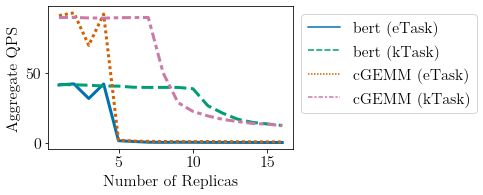

In [12]:
# plot = plotThroughput(thrResults)

plotBig = plotThroughput({ k: v for k, v in thrResults.items() if k in ['bert', 'cGEMM']})
plotBig.figure.savefig("figs/throughputHighMem.png", dpi=300, bbox_inches='tight')

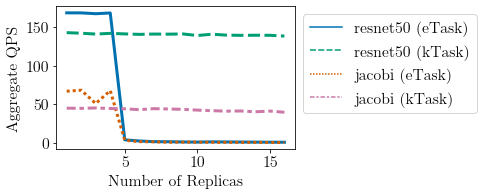

In [13]:
plotSmall = plotThroughput({ k: v for k, v in thrResults.items() if k in ['resnet50', 'jacobi']})
plotSmall.figure.savefig("figs/throughputLowMem.png", dpi=300, bbox_inches='tight')

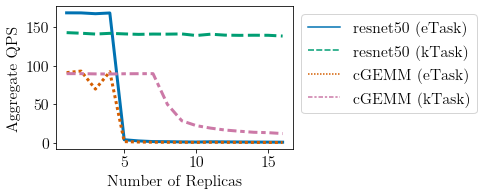

In [14]:
plotSmall = plotThroughput({ k: v for k, v in thrResults.items() if k in ['resnet50', 'cGEMM']})
plotSmall.figure.savefig("figs/throughputResnetCGEMM.png", dpi=300, bbox_inches='tight')

# Microbench

In [15]:
# microMeans, microStds = util.loadMicroSuite(resBaseDir / 'micro' / 'complexCutlass')
microMeans, microStds = util.loadMicroSuite(resBaseDir / 'micro' / 'testModel')
microMeans

,kaasWarm,kaasCold,actWarm,actCold
t_kernel,0.514074,0.525357,0.477180,0.478614
t_cudaMM,0.290179,1.455736,0.060476,1.248028
t_kernel_init,0.000000,0.409317,0.000000,0.633956
t_cuda_copy,1.288676,7.063365,1.530342,5.433591
t_data_layer,2.960047,5.464089,2.509618,4.374528
t_other,5.218025,6.626640,4.954002,425.960088
t_e2e,10.271001,21.544504,9.531617,438.128805


In [16]:
def getLimits(pltDF):
    totalHeights = pltDf.transpose().sum()
    maxHeight = totalHeights.max()

    threshold = 0.25
    bigHeights = totalHeights[totalHeights > maxHeight * threshold]
    minBig = bigHeights.min()
    
    smallHeights = totalHeights[totalHeights < maxHeight * threshold]
    maxSmall = smallHeights.max()

    return ((0, maxSmall * 1.2), (minBig * 0.7, maxHeight * 1.2))
    
    
def plotMicroBroken(pltDF, title=''):
    limits = getLimits(pltDF)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios" : [0.5, 1]})
    
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x',which='both',bottom=False)
    ax2.spines['top'].set_visible(False)
    
    ax2.set_ylim(limits[0][0], limits[0][1])
    ax1.set_ylim(limits[1][0], limits[1][1])
    
    pltDF.plot(kind='bar', stacked=True, ax=ax1, legend=None)
    pltDF.plot(kind='bar', stacked=True, ax=ax2, legend=None)
    
    make_hatches(ax1, pltDF)
    make_hatches(ax2, pltDF)
    
    # sets the slash on the break on the axis
    for tick in ax2.get_xticklabels():
        tick.set_rotation(0)
    d = .015  
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)      
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)  
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    
    ax1.set_title(title)
    
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax1.tick_params(axis='x', rotation=0)
    ax2.tick_params(axis='x', rotation=0)
    
    ax2.set_ylabel("Time (ms)")
    ax2.yaxis.set_label_coords(-0.1, 0.85)
    
    ax2.get_legend().remove()
    ax1.legend(bbox_to_anchor=[1, 0.5])
    # Skinny legend
#     ax1.legend(loc='center left', bbox_to_anchor=[1,0.5])
    # Regular readable legend off to the side
#     ax1.legend(loc='center left', bbox_to_anchor=[1,-1])
    
    return fig

def cleanForPlot(rawDf):
    pltDf = rawDf.transpose().drop(columns=['t_e2e'])
    pltDf = pltDf.rename(columns={"t_kernel": "Kernel Run", 't_cudaMM': "GPU Mem Alloc", 't_kernel_init': 'Kernel Init',
                                 "t_cuda_copy": "GPU Copy", "t_data_layer": "Data Layer", "t_other": "Overheads"})
    pltDf = pltDf.rename(index={"kaasWarm": f"{kaasName}\n(warm)", "kaasCold": f"{kaasName}\n(cold)",
                                "actCold": f"{baselineName}\n(cold)", "actWarm": f"{baselineName}\n(warm)"})
#     print(pltDf.index)
#     return pltDf.rename(index={'kaasWarm': "KaaS (warm)"}, errors='ignore')
    return pltDf

def plotLegend(pltDf):
    plot = pltDf.plot(kind='bar', stacked=True)
    make_hatches(plot, pltDf)
    
#     plot.legend(ncol=6, loc='lower left', bbox_to_anchor=[-0.25,1])
    
    label_params = plot.get_legend_handles_labels()
    figl, axl = plt.subplots()
    axl.axis(False)
    axl.legend(*label_params, loc="center", ncol=3, bbox_to_anchor=(0.5, 0.5), prop={"size":50})
    return figl 

def plotMicro(pltDf):
    plot = pltDf.plot(kind='bar', stacked=True, figsize=(3.8,3), width=0.7)
    plot.tick_params(axis='x', rotation=0)
#     plot = pltDf.plot(kind='barh', stacked=True)
    make_hatches(plot, pltDf)
    plot.legend().remove()
#     plot.legend(loc='upper left', bbox_to_anchor=[1,1])
#     plot.legend(ncol=6, loc='lower left', bbox_to_anchor=[-0.25,1])
    plot.set_ylabel("Time (ms)")
    return plot

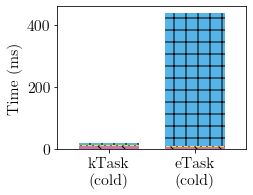

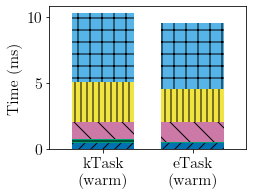

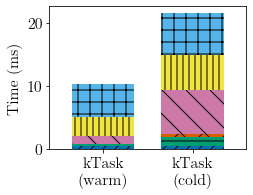

In [17]:
# pltDf = microMeans.transpose().drop(columns=['t_e2e'])
pltDf = cleanForPlot(microMeans)

# plot = plotMicro(pltDf.loc[['KaaS (warm)', 'Actor (warm)']])
# plot = plotMicro(pltDf.loc[['KaaS (warm)', 'FaaS+GPU (warm)']])
# plot = plotMicro(pltDf.loc[['KaaS (cold)', 'FaaS+GPU (cold)']])
# plot = plotMicro(pltDf.loc[['KaaS (warm)', 'KaaS (cold)']])

# legendPlot = plotLegend(pltDf.loc[[f'{kaasName}\n(cold)']])
# legendPlot.savefig("figs/microLegend.png", dpi=300, bbox_inches='tight')
plot = plotMicro(pltDf.loc[[f'{kaasName}\n(cold)', f'{baselineName}\n(cold)']])
plot.figure.savefig("figs/microCold.png", dpi=300, bbox_inches='tight')

plot = plotMicro(pltDf.loc[[f'{kaasName}\n(warm)', f'{baselineName}\n(warm)']])
plot.figure.savefig("figs/microWarm.png", dpi=300, bbox_inches='tight')

plot = plotMicro(pltDf.loc[[f'{kaasName}\n(warm)', f'{kaasName}\n(cold)']])
plot.figure.savefig("figs/microKaasOnly.png", dpi=300, bbox_inches='tight')

In [18]:
# 